# Energy consumption prediction using LSTM

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States.
The hourly power consumption data comes from PJM's website and are in megawatts (MW).

Dataset:
https://www.kaggle.com/robikscube/hourly-energy-consumption

For inspiration:
- https://www.kaggle.com/msripooja/hourly-energy-consumption-time-series-rnn-lstm
- https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb
- https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb

Files used:
- Dominion Virginia Power (DOM) - estimated energy consumption in Megawatts (MW)
- Duquesne Light Co. (DUQ) - estimated energy consumption in Megawatts (MW)

In [123]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [124]:
import zipfile

# unzip archive with 1000 dogs and 1000 cats
archive_dir = 'energy_consumption/'
dom_csv = 'DOM_hourly.csv'
duq_csv = 'DUQ_hourly.csv'

for csv_file in [dom_csv, duq_csv]:
    if not os.path.exists(archive_dir + csv_file):
        with zipfile.ZipFile(archive_dir + csv_file + '.zip', 'r') as zip_ref:
            zip_ref.extractall(archive_dir)

In [125]:
# observations are recorded every hour
dataset_dom = pd.read_csv(archive_dir + dom_csv, index_col='Datetime', parse_dates=['Datetime'])
dataset_dom.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


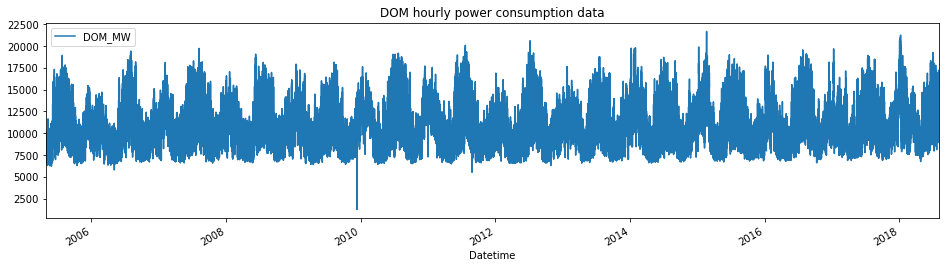

In [126]:
dataset_dom.plot(figsize=(16,4),legend=True)
plt.title('DOM hourly power consumption data')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002552F2FBE80>]],
      dtype=object)

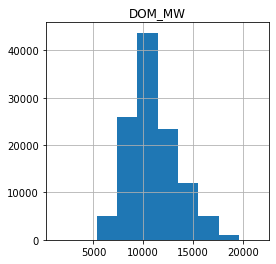

In [127]:
dataset_dom.hist(bins=10, figsize=(4, 4))

In [128]:
dataset_duq = pd.read_csv(archive_dir + duq_csv, index_col='Datetime', parse_dates=['Datetime'])
dataset_duq.head()

,DUQ_MW
Datetime,
2005-12-31 01:00:00,1458.0
2005-12-31 02:00:00,1377.0
2005-12-31 03:00:00,1351.0
2005-12-31 04:00:00,1336.0
2005-12-31 05:00:00,1356.0


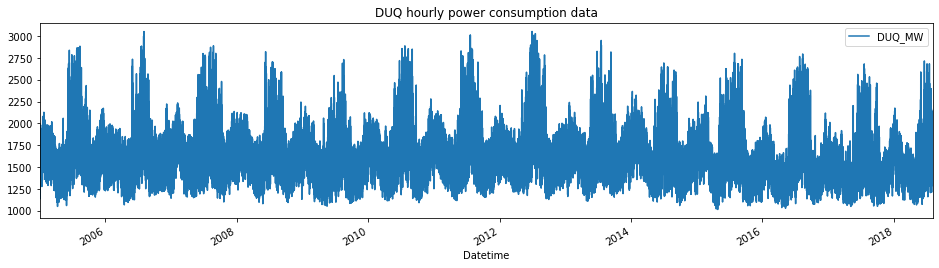

In [129]:
dataset_duq.plot(figsize=(16,4),legend=True)
plt.title('DUQ hourly power consumption data')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002553138FE48>]],
      dtype=object)

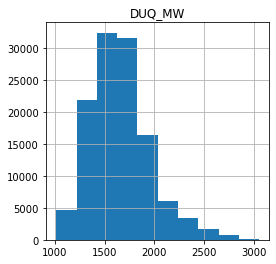

In [130]:
dataset_duq.hist(bins=10, figsize=(4, 4))

In [131]:
# identify missing or zero data
for ds in [dataset_dom, dataset_duq]:
    # get number of values with 0 value
    print('|Zeros:',ds.isin([0]).sum(),', missing:', ds.isna().sum(), ', total:', len(ds))

|Zeros: DOM_MW    0
dtype: int64 , missing: DOM_MW    0
dtype: int64 , total: 116189
|Zeros: DUQ_MW    0
dtype: int64 , missing: DUQ_MW    0
dtype: int64 , total: 119068


In [132]:
TRAIN_SPLIT = 80000
# 12 hour
SEQ_LENGTH = 12

In [133]:
import sklearn.preprocessing

def get_data(dataset, seq_len):
    X = []
    y = []
    for i in range(seq_len, len(dataset)):
        X.append(dataset.iloc[i-seq_len : i, 0])
        y.append(dataset.iloc[i, 0])
        
    return (X,y)

def normalize_data(dataset, col_name):    
    # detect scaling on training set only
    scaler = sklearn.preprocessing.MinMaxScaler()    
    scaler.fit(dataset[col_name].values[:TRAIN_SPLIT].reshape(-1,1))        
    # replace with scale values
    dataset[col_name] = scaler.transform(dataset[col_name].values.reshape(-1,1))
    return dataset

In [134]:
# Use DOM provider for predictions
dataset_norm = normalize_data(dataset_dom.copy(), 'DOM_MW')
dataset_norm.shape

(116189, 1)

In [135]:
(X, y) = get_data(dataset_norm, SEQ_LENGTH)

X_train = X[:TRAIN_SPLIT]
y_train = y[:TRAIN_SPLIT]    

X_test = X[TRAIN_SPLIT:]
y_test = y[TRAIN_SPLIT:]

X_train = np.array(X_train)
y_train = np.array(y_train)   
X_test = np.array(X_test)
y_test = np.array(y_test)
    
#4 reshape data to input into RNN models
X_train = np.reshape(X_train, (TRAIN_SPLIT, SEQ_LENGTH, 1))   
X_test = np.reshape(X_test, (X_test.shape[0], SEQ_LENGTH, 1))

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (80000, 12, 1)
y_train.shape =  (80000,)
X_test.shape =  (36177, 12, 1)
y_test.shape =  (36177,)


In [90]:
#print('X_train:', X_train, 'y_train:', y_train)

In [137]:
# Create NN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras import optimizers

input_shape = (SEQ_LENGTH,1)

# define a sequential model
model = Sequential()

model.add(LSTM(64, input_shape=input_shape, return_sequences = True))
model.add(LSTM(32, return_sequences = False))
model.add(Dense(1))
model.add(Activation('linear'))

opt_Adam = optimizers.Adam(lr=0.001, beta_1=0.8, beta_2=0.8, epsilon=1e-07, decay=0.0, amsgrad=False)

# build model
model.compile(optimizer=opt_Adam,
             loss='mean_absolute_error',
             metrics=['mae'])

In [138]:
epochs = 30

history = model.fit(
    X_train,
    y_train,
    batch_size=200,
    epochs=epochs,
    validation_data=(X_test, y_test),
    shuffle=False
)

Train on 80000 samples, validate on 36177 samples
Epoch 1/30
80000/80000 [==============================] - 15s 186us/sample - loss: 0.0605 - mae: 0.0605 - val_loss: 0.0400 - val_mae: 0.0400
Epoch 2/30
80000/80000 [==============================] - 12s 147us/sample - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0218 - val_mae: 0.0218
Epoch 3/30
80000/80000 [==============================] - 12s 144us/sample - loss: 0.0162 - mae: 0.0162 - val_loss: 0.0147 - val_mae: 0.0147
Epoch 4/30
80000/80000 [==============================] - 13s 165us/sample - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0169 - val_mae: 0.0169
Epoch 5/30
80000/80000 [==============================] - 12s 145us/sample - loss: 0.0143 - mae: 0.0143 - val_loss: 0.0153 - val_mae: 0.0153
Epoch 6/30
80000/80000 [==============================] - 13s 160us/sample - loss: 0.0142 - mae: 0.0142 - val_loss: 0.0141 - val_mae: 0.0141
Epoch 7/30
80000/80000 [==============================] - 12s 153us/sample - loss: 0.0144 - mae: 0.0144 

In [139]:
def plot_model_history(model_history):
    history_dict = model_history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)

    plt.plot(epochs, loss_values, 'b', label='Training loss', color='blue')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss', color='yellow')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

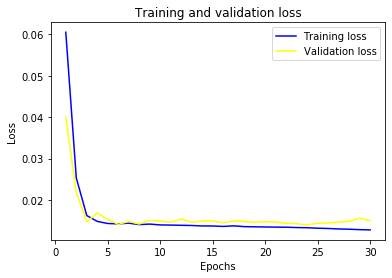

In [140]:
plot_model_history(history)

In [141]:
def plot_predictions(y_test, y_predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(y_test, color='blue',label='Actual power consumption data')
    plt.plot(y_predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

In [142]:
y_predicted = model.predict(X_test)

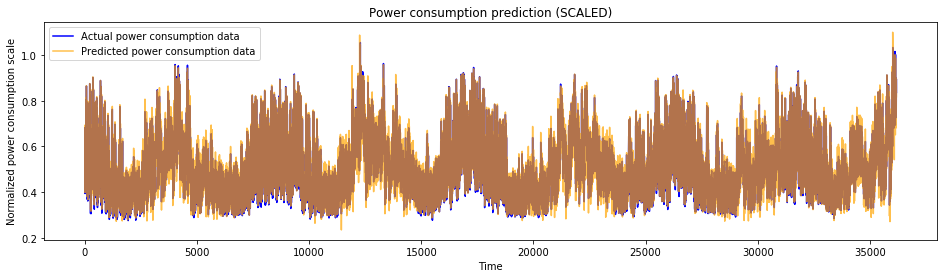

In [122]:
plot_predictions(y_test, y_predicted, "Power consumption prediction (SCALED)")

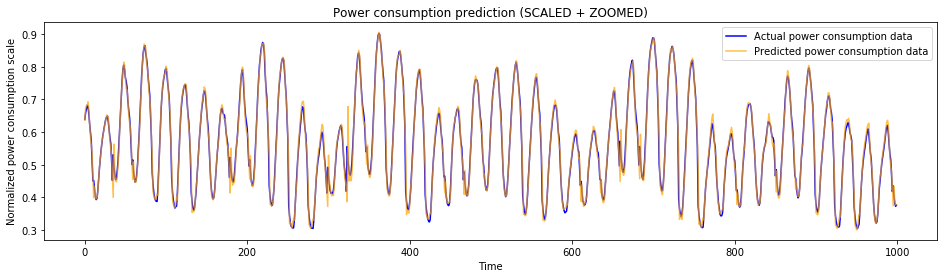

In [143]:
plot_predictions(y_test[:1000], y_predicted[:1000], "Power consumption prediction (SCALED + ZOOMED)")